## CSV 1 - CONSUMO ENERGIA


### VARIÁVEIS CATEGÓRICAS

DATA; ENERGIA ELETRICA EM KWH

In [14]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from dateutil.parser import parse


sns.set_context('notebook')
sns.set_style('darkgrid')


In [15]:
data = 'ipeadata_consumo_energia.csv'

In [16]:
df = pd.read_csv(data, sep=';', skiprows=0)

In [17]:
data_dia = pd.Series(df['Data'])
consumo = pd.Series(df['Energia elétrica - consumo - residência - quantidade - GWh - Eletrobras - ELETRO12_CEERES12'])

df = pd.DataFrame({'Data': data_dia, 'Consumo': consumo})



In [18]:
df.head()

,Data,Consumo
0,1976.01,"1259,8"
1,1976.02,"1161,6"
2,1976.03,"1191,6"
3,1976.04,"1180,4"
4,1976.05,"1205,2"


In [19]:
df.dtypes

Data       float64
Consumo     object
dtype: object

In [20]:

df["Data"] = df["Data"].astype('str')


In [21]:
df[['Ano', 'Mes']] = df['Data'].str.split('.', expand=True)


In [22]:
df['AnoMes'] = pd.to_datetime(df['Ano'] + df['Mes'], format='%Y%m')
df['AnoMes'] = df['AnoMes'].astype('object')

In [23]:
df.drop('Data', axis=1, inplace=True)

In [24]:
df.head()

,Consumo,Ano,Mes,AnoMes
0,"1259,8",1976,01,1976-01-01 00:00:00
1,"1161,6",1976,02,1976-02-01 00:00:00
2,"1191,6",1976,03,1976-03-01 00:00:00
3,"1180,4",1976,04,1976-04-01 00:00:00
4,"1205,2",1976,05,1976-05-01 00:00:00


In [25]:
df["Consumo"] = df["Consumo"].astype(str)

In [26]:
df['Consumo'] = df['Consumo'].str.replace(',', '.').astype(float)

In [27]:
df['Consumo'].dtype

dtype('float64')

In [28]:
df['Ano'] = pd.to_numeric(df['Ano'])
df['Mes'] = pd.to_numeric(df['Mes'])

In [29]:
df.dtypes

Consumo    float64
Ano          int64
Mes          int64
AnoMes      object
dtype: object

In [30]:
print(df["Consumo"].mean())

6302.118425760286


In [31]:
## create a frequency of Consumo column to be monthly
 # x = df['Consumo'].resample('M').mean()

### Observações sobre o gráfico abaixo:
> - Atipicidade no gráfico: Há 20 anos, a continuação do roteiro envolveu um racionamento de energia na maior parte do país, com a redução compulsória de 20% do consumo de eletricidade. Analisando o gráfico, por volta dos anos 2000 o eixo y tinha o valor aproximado de 7500 GWh, e, com a redução do consumo de energia em aproximadamente 20%, há um gap no nosso gráfico cujo valor cai para 6000 GWh.
> - Os componentes da série temporal são: eixo Y - Consumo em GWh e o eixo X - AnoMês

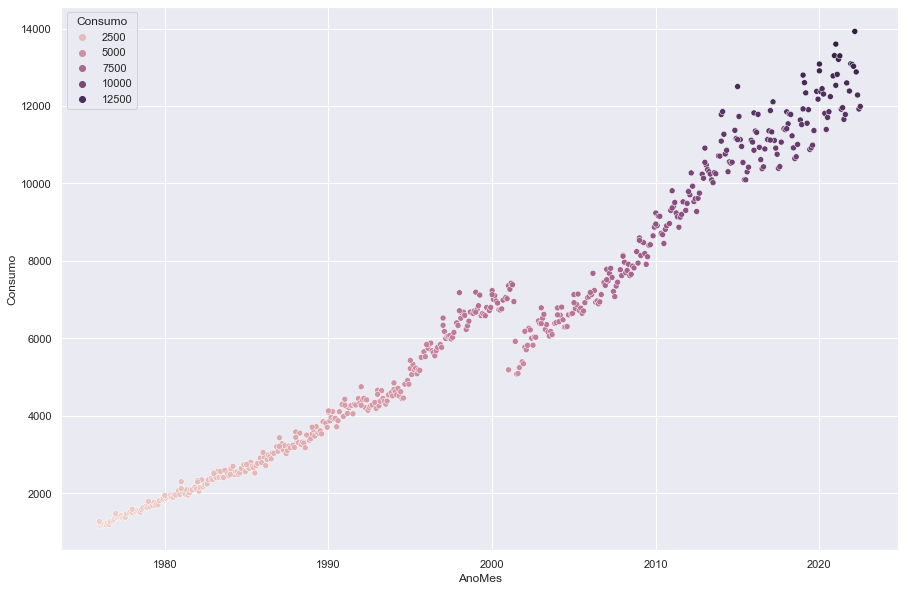

In [32]:
plt.figure(figsize=(15,10))
sns.scatterplot(x='AnoMes', y='Consumo', data=df, hue='Consumo', sizes=(20, 200));



In [33]:
valor_min = df["Consumo"].describe()[3]
valor_max = df["Consumo"].describe()[7]
print(f"O valor mínimo e máximo são: {valor_min} GWh e {valor_max} GWh")

O valor mínimo e máximo são: 1161.6 GWh e 13926.0 GWh


In [34]:
df["AnoMes"].head()

0    1976-01-01 00:00:00
1    1976-02-01 00:00:00
2    1976-03-01 00:00:00
3    1976-04-01 00:00:00
4    1976-05-01 00:00:00
Name: AnoMes, dtype: object

<AxesSubplot:ylabel='Frequency'>

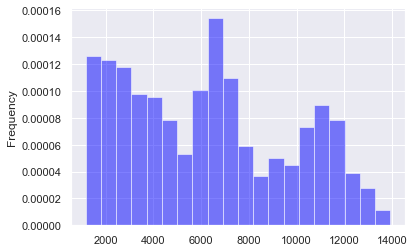

In [35]:
df['Consumo'].plot(kind='hist', bins=20, density=True, alpha=0.5, color='blue')

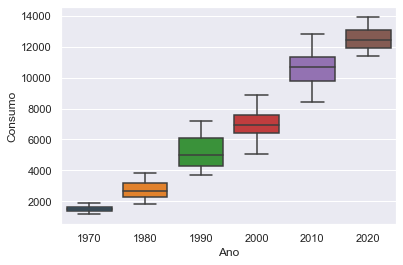

In [36]:
sns.boxplot(x=df['Ano']//10 * 10, y='Consumo', data=df);

In [37]:
x = df['AnoMes'].values
y1 = df['Consumo']

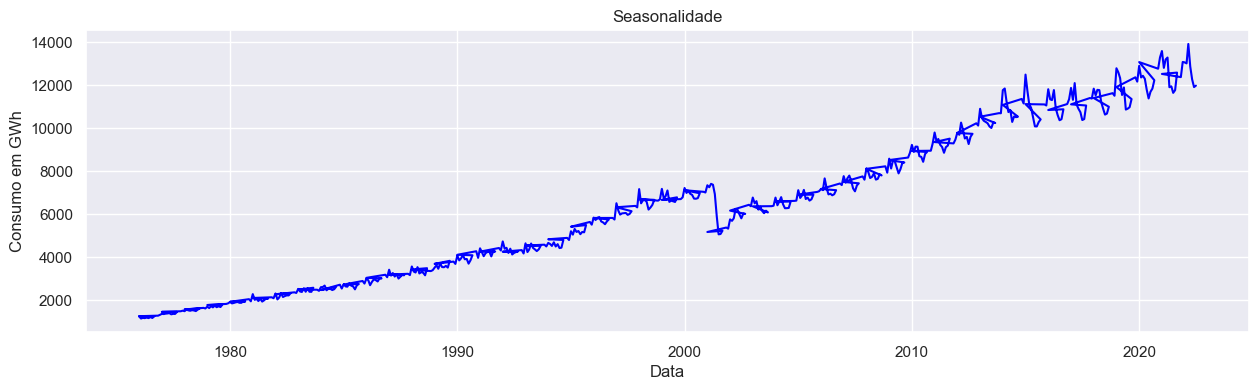

In [38]:
def plot_df(df, x, y, title="", xlabel='Data', ylabel='Consumo em GWh', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    
plot_df(df, x = x, y= y1, title='Seasonalidade')

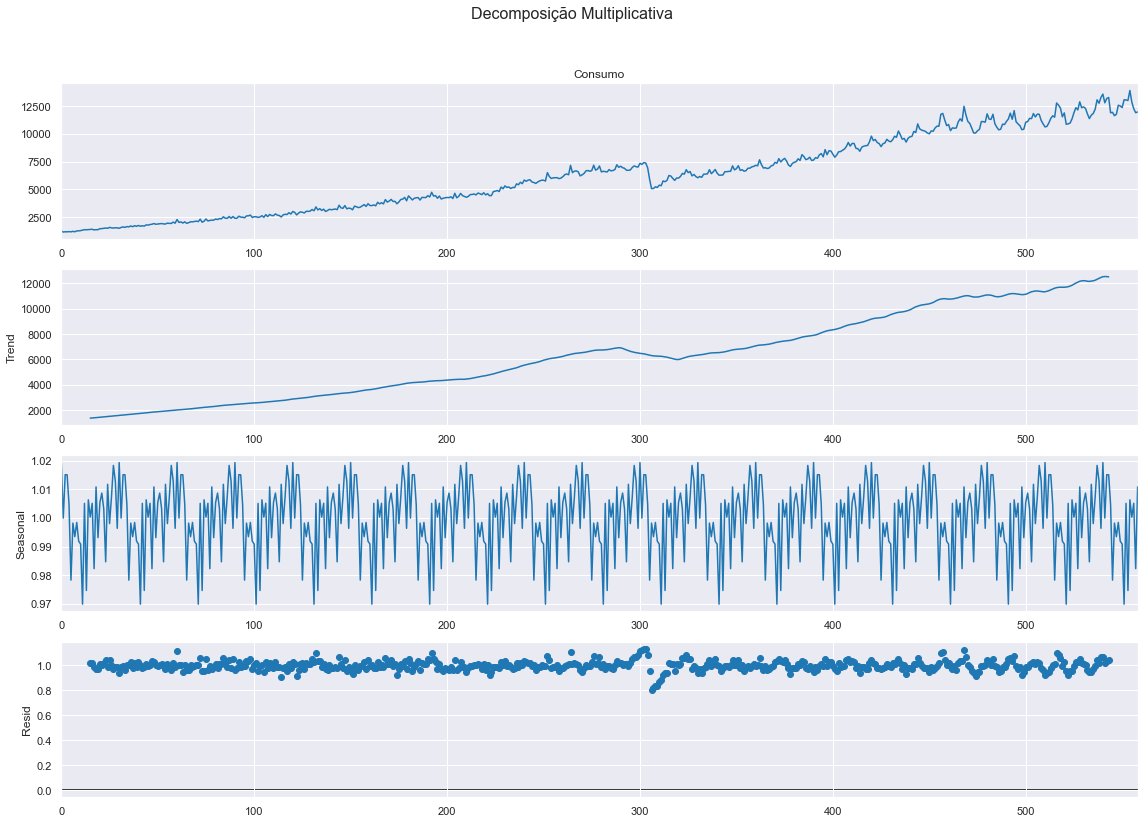

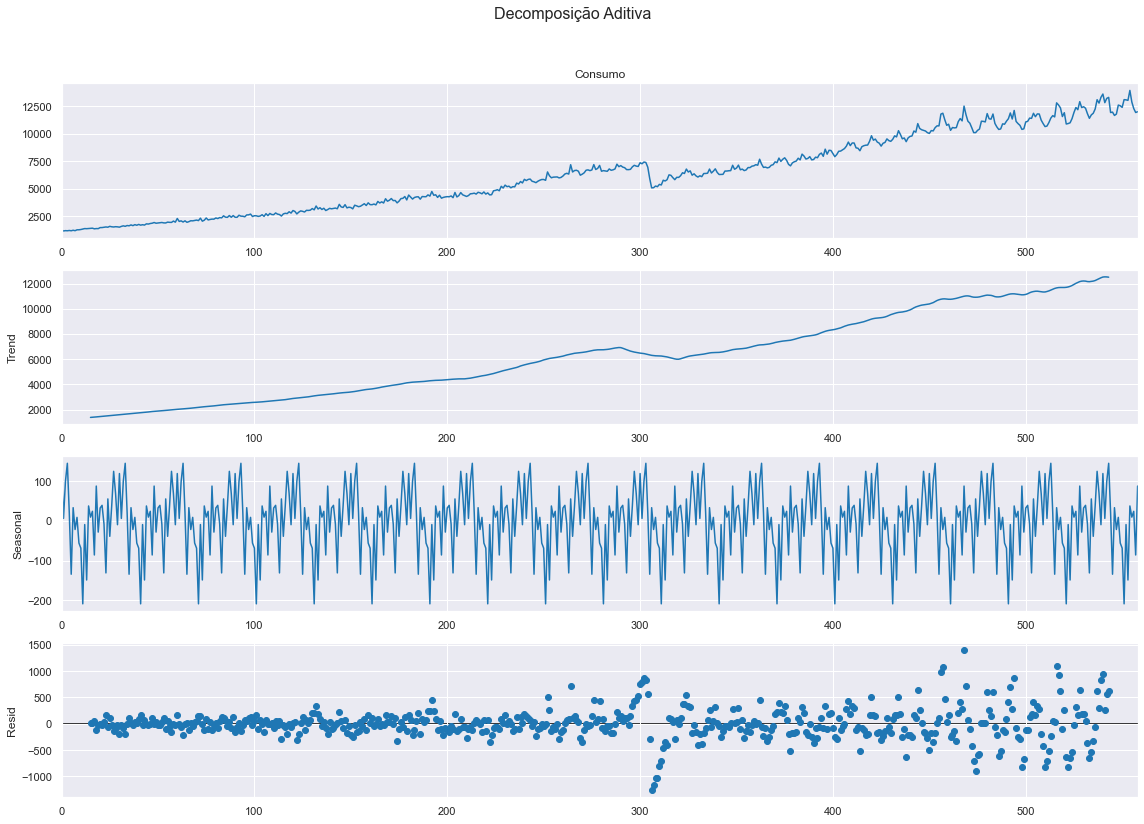

In [39]:
multiplicative_decomposition = seasonal_decompose(df['Consumo'], model='multiplicative', period=30)

additive_decomposition = seasonal_decompose(df['Consumo'], model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Decomposição Multiplicativa', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Decomposição Aditiva', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

## Exemplo de resíduo